In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from os import path

import netCDF4
import numpy as np
np.set_printoptions(suppress=True)
import os
from ipywidgets import interact,widgets,fixed
import matplotlib.pyplot as plt

from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.metrics import get_iou_perClass
from climatenet.utils.model_evaluation import bootstrap_ious, compute_bootstrap_pct_positive_diff, plot_bootstrap_results, compute_bootstrap_confidence_intervals
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Using bootstrapping to compare performance of two models

load 2 seperate models (for this example, I used the same model with a different config because I only had one model)

In [2]:
config1 = Config('../models/original_baseline_model/config.json')
model1 = CGNet(model_path='../models/original_baseline_model')
test1 = ClimateDatasetLabeled('../data/test', config1)

config2 = Config('../models/new_baseline_model/config.json')
model2 = CGNet(model_path='../models/original_baseline_model')
test2 = ClimateDatasetLabeled('../data/test', config2)

We can evalute the performance of the two models as shown below, but how do we know if the difference between the metrics is statistically significant?

In [3]:
eval1 = model1.evaluate(test1)
eval2 = model2.evaluate(test2)

print(eval1)
print(eval2)

100%|██████████| 61/61 [01:48<00:00,  1.77s/it]

(0.78616999114146, array([0.93057981, 0.33438732, 0.39306456]))
(0.7999157465872218, array([0.93840732, 0.03001085, 0.0002971 ]))


One way we can evaluate this is by using bootstapping, as shown below

In [4]:
cms1 = model1.get_cm_for_each_file(test1)
cms2 = model2.get_cm_for_each_file(test2)

100%|██████████| 61/61 [01:39<00:00,  1.63s/it]


fraction of bootstrap samples where model 2 outperforms model 1 on background class, class 1, class 2, and average across all classes:
[0.9894, 0.0, 0.0, 0.0]
confidence interval for model2 iou - model 1 iou 1 on background class, class 1, class 2, and average across all classes:
[[ 0.00124619  0.01423588]
 [-0.35118198 -0.25124087]
 [-0.42003677 -0.36527151]
 [-0.25011332 -0.20849975]]


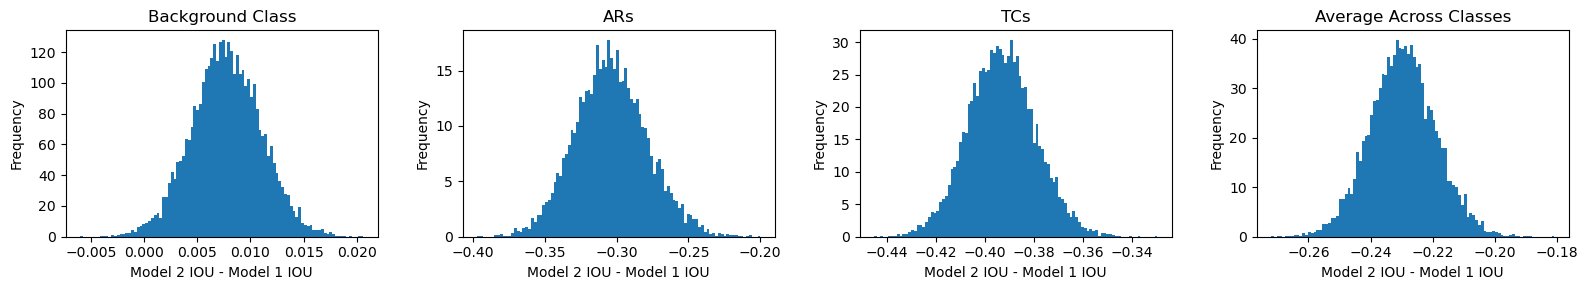

In [20]:
diff_iou = bootstrap_ious(cms1, cms2)
print("fraction of bootstrap samples where model 2 outperforms model 1 on background class, class 1, class 2, and average across all classes:")
print(compute_bootstrap_pct_positive_diff(diff_iou))
print("confidence interval for model2 iou - model 1 iou 1 on background class, class 1, class 2, and average across all classes:")
print(compute_bootstrap_confidence_intervals(diff_iou))
plot_bootstrap_results(diff_iou)